In [40]:
# %cd /content/drive/My Drive/ColabNotebooks/mnist
# %ls

In [41]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [42]:
def makedir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)

In [43]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "D:\\HDD_Study\\HDD_Github\\Gesture_Game_lerning"
# data_dir = "C:\ex\sen\data\max_square\\train_val"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
#結果出力ディレクトリ
output_name = "model"
# Number of classes in the dataset
num_classes = 3
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for
num_epochs = 10
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

binary = True
# last or best
last = True

output_base_dir = "C:\\Users\\H3rb\\source\\GitHub\\HandGesture_Game"
out_dir = os.path.join(output_base_dir,output_name)
# if os.path.exists(out_dir):
#   print("出力ディレクトリ名が被っているよ")
#   sys.exit()

makedir(out_dir)

In [44]:
from HandGesture_module_v2 import ai as gestureai

model_name='resnet'
load_num_classes=10
feature_extract=False

model_ft, input_size = gestureai.initialize_model(model_name, load_num_classes, feature_extract, use_pretrained=True, binary=True)
model_ft.load_state_dict(torch.load(".\\mnist_model\\model_weights.pth")) #変更する
model_ft = gestureai.henkou_num_class(model_ft,num_classes, feature_extract)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ft = model_ft.to(device)

In [45]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(0,360),expand=True),
        transforms.Resize(input_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
}
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [46]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [47]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [48]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_acc_hist_tensor, val_acc_hist_tensor = gestureai.train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, last, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------
train Loss: 0.1257 Acc: 0.9667
val Loss: 0.0589 Acc: 0.9789

Epoch 1/9
----------
train Loss: 0.0089 Acc: 0.9998
val Loss: 0.0373 Acc: 0.9867

Epoch 2/9
----------
train Loss: 0.0069 Acc: 0.9987
val Loss: 0.0495 Acc: 0.9822

Epoch 3/9
----------
train Loss: 0.0039 Acc: 0.9998
val Loss: 0.0363 Acc: 0.9844

Epoch 4/9
----------
train Loss: 0.0026 Acc: 0.9994
val Loss: 0.0576 Acc: 0.9811

Epoch 5/9
----------
train Loss: 0.0022 Acc: 0.9998
val Loss: 0.0521 Acc: 0.9811

Epoch 6/9
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0393 Acc: 0.9856

Epoch 7/9
----------
train Loss: 0.0019 Acc: 0.9998
val Loss: 0.0519 Acc: 0.9811

Epoch 8/9
----------
train Loss: 0.0025 Acc: 0.9994
val Loss: 0.0316 Acc: 0.9878

Epoch 9/9
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.0449 Acc: 0.9822

Training complete in 2m 47s
Best val Acc: 0.987778


In [49]:
from PIL import Image

def tensor_to_np(inp, type):
    "imshow for Tesor"
    if type == "imagenet":
        inp = inp.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp

    elif type == "gray":
        inp = inp.numpy()
        # inp = inp.numpy().transpose((1,2,0))
        print('gray')
        inp = np.clip(inp, 0, 1)
        return inp

def false_img_save(pred, label, input, false_img_count):
    pil_img = Image.fromarray(input)
    makedir(out_dir + 'error/pred_' + str(class_names[pred.item()]) + '_label_' + str(class_names[label.item()]))
    pil_img.save(out_dir + f'error/pred_{class_names[pred.item()]}_label_{class_names[label.item()]}/{false_img_count}.jpg')

-------
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0., 

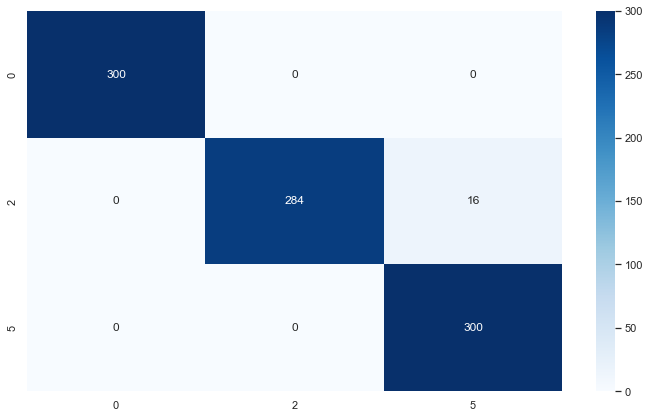

In [50]:
import pandas as pd
import seaborn as sn

def val_model(model, dataloaders, optimizer):
    false_img_count = 0
    phase = 'val'
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
            print("-------")
            print(inputs)
            print(inputs.shape)

            print("-------")
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            #######################################################
            for i in range(inputs.size()[0]):
                if preds[i] != labels[i]:
                    if binary:
                        type = "gray"
                    else:
                        type = "imagenet"

                    input = tensor_to_np(inputs.cpu().data[i], type)
                    # print(input)
                    input *= 255
                    print(input[0].shape)
                    print(input[0])
                    input = input[0].astype(np.uint8)
                    
                    false_img_save(preds[i], labels[i], input, false_img_count)
                    false_img_count += 1

            #######################################################

            for t_confusion_matrix, p_confusion_matrix in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t_confusion_matrix.long(), p_confusion_matrix.long()] += 1
    
    confusion_matrix_numpy = confusion_matrix.to('cpu').detach().numpy().copy()
    df_cmx = pd.DataFrame(confusion_matrix_numpy, index=class_names, columns=class_names)
    plt.figure(figsize = (12, 7))
    sn.set(font_scale = 1)
    sn.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues')
    plt.savefig(os.path.join(out_dir,"confusion_matrix.png"))
    sn.set(font_scale = 1)

val_model(model_ft, dataloaders_dict, optimizer_ft)

In [51]:
print(class_names)

['0', '2', '5']


In [52]:
def save_txtfile(data, outpath):
  file = outpath
  fileobj = open(file, "w", encoding = "utf_8")
  for index , i in enumerate(data):
    if index == len(data) - 1:
      fileobj.write(f"{i}")
    else:
      fileobj.write(f"{i},")

  fileobj.close()

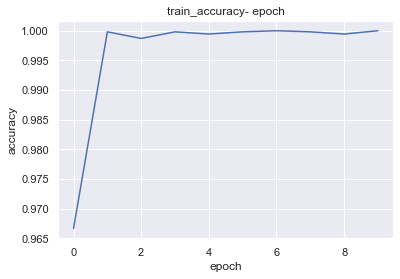

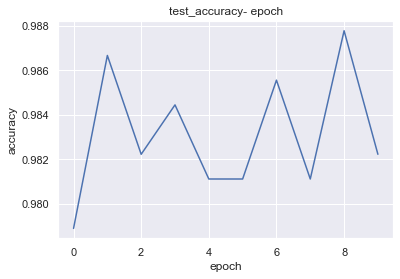

In [53]:
train_acc_hist = []
val_acc_hist = []

for i in train_acc_hist_tensor:
  train_acc_hist.append(float(i.item()))

for i in val_acc_hist_tensor:
  val_acc_hist.append(float(i.item()))

plt.plot(train_acc_hist)
plt.title("train_accuracy- epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig(os.path.join(out_dir,"train_acc.png"))
plt.show()

plt.plot(val_acc_hist)
plt.title("test_accuracy- epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.savefig(os.path.join(out_dir,"val_acc.png"))
plt.show()

save_txtfile(train_acc_hist, os.path.join(out_dir,"train_acc_hist.txt"))
save_txtfile(val_acc_hist, os.path.join(out_dir,"val_acc_hist.txt"))

In [54]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                
                print(inputs.cpu().data[j].size())
                ax.imshow(tensor_to_np(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
# visualize_model(model_ft, dataloaders_dict)

In [16]:
torch.save(model_ft.state_dict(), os.path.join(out_dir,'model_weights.pth'))

In [25]:
# LibTorch形式でモデルをエクスポートします

#バッチサイズ32　チャンネル1　入力サイズ224x224
input_tensor = torch.randn(1,1, 224, 224)
# input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda()

traced_script_module = torch.jit.trace(model_ft, input_tensor)
traced_script_module.save(os.path.join(out_dir,'model_weights_c++_11224224.pt'))




input_tensor = torch.randn(32,1, 224, 224)
# input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda()

traced_script_module = torch.jit.trace(model_ft, input_tensor)
traced_script_module.save(os.path.join(out_dir,'model_weights_c++_321224224.pt'))

In [17]:
from torchinfo import summary


summary(model_ft)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [18]:
print(list(model_ft.parameters()))

[Parameter containing:
tensor([[[[ 0.1116, -0.0809,  0.0826,  ..., -0.0839,  0.0143, -0.0816],
          [ 0.1179, -0.1306, -0.0096,  ...,  0.0614, -0.0138, -0.0158],
          [ 0.0316,  0.0719,  0.0668,  ...,  0.0662, -0.0817,  0.0304],
          ...,
          [ 0.0390, -0.1324,  0.0144,  ..., -0.0041, -0.1241,  0.0281],
          [ 0.1240, -0.1004,  0.0294,  ...,  0.0468, -0.0991, -0.0970],
          [ 0.0847, -0.0759, -0.0211,  ...,  0.1140,  0.1414, -0.0348]]],


        [[[ 0.0101,  0.0118,  0.1399,  ...,  0.1253, -0.0514,  0.0990],
          [ 0.1392,  0.0427, -0.0860,  ..., -0.0412,  0.0326, -0.1026],
          [-0.0559,  0.0578, -0.0177,  ..., -0.0763, -0.1030,  0.0476],
          ...,
          [ 0.0537,  0.1147,  0.1373,  ...,  0.0853,  0.1320,  0.1011],
          [ 0.0030, -0.1450, -0.0516,  ...,  0.0480, -0.0599, -0.0292],
          [ 0.0407, -0.1272, -0.0529,  ..., -0.0696,  0.1045,  0.0396]]],


        [[[ 0.0439,  0.0362,  0.0914,  ..., -0.0103, -0.0843, -0.0679],
   

In [19]:
print(model_ft)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# LibTorch形式でモデルをエクスポートします

#バッチサイズ32　チャンネル1　入力サイズ224x224
input_tensor = torch.randn(1, 244, 244)
model = model_ft
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda()
output = model(input_tensor)
print(output)
# traced_script_module = torch.jit.trace(model_ft, output)
# traced_script_module.save(os.path.join(out_dir,'model_weights_c++.ptc'))
# traced_script_module.save(os.path.join(out_dir,'model_weights_c++.pt'))

tensor([[ 1.0567, -2.0146,  2.5387]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [21]:
# LibTorch形式でモデルをエクスポートします

#バッチサイズ32　チャンネル1　入力サイズ224x224
input_tensor = torch.randn(1,1, 224, 224)
# input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.cuda()

traced_script_module = torch.jit.trace(model_ft, input_tensor)
traced_script_module.save(os.path.join(out_dir,'model_weights_c++.ptc'))
traced_script_module.save(os.path.join(out_dir,'model_weights_c++.pt'))

In [22]:
print(torch.__version__)

1.11.0


In [23]:
torch.save(model_ft.state_dict(), 'model.pt')

In [24]:
#C++用簡単なモデルサンプルプログラム
import torch
import torch.nn as nn
import torch.optim as optim

# モデルの定義
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# データの定義
data = torch.randn((100, 10))
labels = torch.randint(low=0, high=2, size=(100,))

# モデルの学習
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {loss.item()}")

# モデルの保存
torch.save(model.state_dict(), "mymodel.pt")

Epoch 1 - Loss: 0.687767744064331
Epoch 2 - Loss: 0.6804932951927185
Epoch 3 - Loss: 0.6743967533111572
Epoch 4 - Loss: 0.6691540479660034
Epoch 5 - Loss: 0.6647560000419617
Epoch 6 - Loss: 0.6609365344047546
Epoch 7 - Loss: 0.6575608849525452
Epoch 8 - Loss: 0.6543869972229004
Epoch 9 - Loss: 0.6513733863830566
Epoch 10 - Loss: 0.6484604477882385


In [25]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")          # CUDAデバイスオブジェクトを作成
    print("CUDAが使用可能です")
    print("現在のCUDAデバイス：", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("CUDAは使用できません")


print("PyTorchバージョン：", torch.__version__)
if torch.cuda.is_available():
    print("CUDAバージョン：", torch.version.cuda)
else:
    print("CUDAは使用できません")

CUDAが使用可能です
現在のCUDAデバイス： NVIDIA GeForce RTX 3070 Ti
PyTorchバージョン： 1.11.0
CUDAバージョン： 11.3


In [4]:
import cv2
import torch
import numpy as np


# Load the saved model
model = torch.load('model/model_weights_c++.pt')

# Load the image using OpenCV
image = cv2.imread('D:\HDD_Study\HDD_PBL\last_test\mix\\train\\2\\20221221_0110_4.jpg', cv2.IMREAD_GRAYSCALE)
# Resize the image to the desired size (e.g., 224x224)
image = cv2.resize(image, (224, 224))

# Convert the image to a PyTorch tensor
tensor = torch.from_numpy(np.expand_dims(np.expand_dims(image, axis=0), axis=0).astype(np.float32)).cuda()
print("choki_image_tensor=")
#torch.set_printoptions(edgeitems=1000)
print(tensor.size())

# Set the model to evaluation mode
model.eval()

# Define some example inputs to pass to the model
input_shape = (1, 1, 224, 224)  # Example input shape
example_input = torch.randn(input_shape).cuda()  # Example input data

# Call the forward() method on the model with the example inputs
output = model(example_input)
output2 = model(tensor)

# Display the input shape used in the forward() method call
print(f"Input shape used in forward(): {example_input.shape}")


max_prob_idx = torch.argmax(output, dim=1)
max_prob_idx2 = torch.argmax(output2, dim=1)
# Assume that `class_labels` is a list of class labels in the same order as the columns of `output`
class_labels = ['goo','choki','par']

# Get the corresponding class label for each example
predicted_labels = [class_labels[idx] for idx in max_prob_idx]
predicted_labels2 = [class_labels[idx] for idx in max_prob_idx2]

# Print the predicted labels
print(predicted_labels)
print("choki = ")
print(predicted_labels2)



choki_image_tensor=
torch.Size([1, 1, 224, 224])
Input shape used in forward(): torch.Size([1, 1, 224, 224])
['par']
choki = 
['choki']
